# Transformer Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path

wd = Path(os.path.dirname(os.path.abspath("__file__"))).parent.resolve()
sys.path.append(str(wd))

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from datetime import datetime, timedelta
from src.models.auction_transformer import AuctionTransformer
from src.models.inference import predict_dataframe

pd.options.display.max_columns = None
pd.options.display.width = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
prediction_time = datetime.strptime("2025-10-13 00:00:00", "%Y-%m-%d %H:%M:%S")
max_hours_back = 24

mappings_dir = '../generated/mappings'

with open(os.path.join(mappings_dir, 'item_to_idx.json'), 'r') as f:
        item_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'context_to_idx.json'), 'r') as f:
    context_to_idx = json.load(f)
    
with open(os.path.join(mappings_dir, 'bonus_to_idx.json'), 'r') as f:
    bonus_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'modtype_to_idx.json'), 'r') as f:
    modtype_to_idx = json.load(f)

feature_stats = torch.load('../generated/feature_stats.pt')

time_left_mapping = {
    'VERY_LONG': 48,
    'LONG': 12,
    'MEDIUM': 2,
    'SHORT': 0.5
}

In [4]:
from src.data.utils import load_auctions_from_sample

data_dir = '../data/tww/auctions/'

df_auctions = load_auctions_from_sample(data_dir, prediction_time, time_left_mapping, item_to_idx, context_to_idx, bonus_to_idx, modtype_to_idx, max_hours_back=max_hours_back)

print("Auctions shape:", df_auctions.shape)
df_auctions[df_auctions['snapshot_time'] == prediction_time].head()

Pass 2/2: rows: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


Built dataframe with 10644575 rows from 138 snapshots [2025-10-10 00:00, 2025-10-16 00:00], include_targets=True
Auctions shape: (10644575, 15)


,id,item_index,bid,buyout,quantity,time_left,context,bonus_lists,modifier_types,modifier_values,snapshot_time,time_offset,hour_of_week,current_hours,hours_on_sale
5552712,265037662,1,0.0,4949.93,1,12.0,0,[],[],[],2025-10-13,0,0,45.0,2.0
5552713,265068752,1,0.0,10000.01,1,12.0,13,[],[],[],2025-10-13,0,0,44.0,3.0
5552714,265341300,1,0.0,1000.35,1,12.0,0,[],[],[],2025-10-13,0,0,42.0,5.0
5552715,265344578,1,0.0,4200.00,1,12.0,0,[],[],[],2025-10-13,0,0,42.0,5.0
5552716,265711142,1,0.0,900.35,1,12.0,0,[],[],[],2025-10-13,0,0,39.0,8.0


In [5]:
model = AuctionTransformer.load_from_checkpoint(
    #'../models/transformer-4M-quantile-how-historical_0/last.ckpt',
    #'../models/transformer-4M-quantile-how-historical/last-v2.ckpt',
    '../models/transformer-4M-quantile-how-historical_24/last-v1.ckpt',
    map_location=device
)

print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')
model.eval()
print('Pre-trained Transformer model loaded successfully.')

Number of model parameters: 4083267
Pre-trained Transformer model loaded successfully.


/home/angel/miniconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.4


In [7]:
from src.models.inference import predict_dataframe

model = model.to('cuda')
df_auctions = predict_dataframe(model, df_auctions, prediction_time, feature_stats, max_hours_back=max_hours_back)

df_predictions = df_auctions[df_auctions['time_offset'] == 0]

print("Mean hours on sale:", df_predictions['hours_on_sale'].mean())
print("Mean prediction:", df_predictions['prediction_q50'].mean())

mae = mean_absolute_error(df_predictions['hours_on_sale'], df_predictions['prediction_q50'])
print(f"Mean absolute error: {mae}")

Mean hours on sale: 17.695691615771857
Mean prediction: 18.272060409373164
Mean absolute error: 2.804689903661871


In [12]:
df_auctions_filtered = df_predictions[df_predictions['current_hours'] == 0]
df_auctions_filtered = df_auctions_filtered[df_auctions_filtered['time_left'] == 12.0]

df_auctions_filtered['prediction_interval'] = df_auctions_filtered['prediction_q90'] - df_auctions_filtered['prediction_q10']

mae = mean_absolute_error(df_auctions_filtered['hours_on_sale'], df_auctions_filtered['prediction_q50'])
print(f"Mean absolute error: {mae} for {len(df_auctions_filtered)} auctions") # 7.17

Mean absolute error: 2.595104270109235 for 1007 auctions


In [14]:
df_auctions_filtered[['item_index', 'buyout','quantity', 'time_left', 'current_hours', 'hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90']].sample(10)

,item_index,buyout,quantity,time_left,current_hours,hours_on_sale,prediction_q10,prediction_q50,prediction_q90
5604355,13379,1500.00,1,12.0,0.0,4.0,3.50,10.90,11.01
5616479,16885,1499.99,1,12.0,0.0,1.0,1.15,10.86,11.06
5619530,17164,430.22,1,12.0,0.0,11.0,0.42,10.13,11.13
5628664,17672,42332.40,1,12.0,0.0,0.0,-0.01,0.16,8.65
5610179,15066,4562.06,1,12.0,0.0,0.0,-0.02,4.48,11.14
5628480,17664,112500.00,1,12.0,0.0,0.0,0.10,0.68,11.17
5615080,16558,19778.99,1,12.0,0.0,11.0,-0.02,4.46,11.02
5615111,16577,20267.65,1,12.0,0.0,11.0,9.77,10.98,11.08
5574977,5084,18317.45,1,12.0,0.0,11.0,3.00,10.93,11.06
5613362,15978,3055.34,1,12.0,0.0,0.0,0.00,0.58,10.88


In [15]:
df_auctions_filtered['coverage'] = (df_auctions_filtered['prediction_q10'] <= df_auctions_filtered['hours_on_sale']) & (df_auctions_filtered['hours_on_sale'] <= df_auctions_filtered['prediction_q90'])
df_auctions_filtered['coverage'].mean()

np.float64(0.8629592850049652)

### Binary classification

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

df_auctions_filtered['sold_gt'] = df_auctions_filtered['hours_on_sale'] <= 6
df_auctions_filtered['sold_pred'] = df_auctions_filtered['prediction_q50'] <= 6.0

num_positive = df_auctions_filtered['sold_gt'].sum()
num_negative = len(df_auctions_filtered) - num_positive

print(f"Total samples: {len(df_auctions_filtered)}")
print(f"Positive (sold ≤ hours): {num_positive}")
print(f"Negative (not sold > hours): {num_negative}")
print(f"Class balance: {num_positive / len(df_auctions_filtered):.2%} positives")

accuracy = accuracy_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])
precision = precision_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])
recall = recall_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])
f1 = f1_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

Total samples: 1007
Positive (sold ≤ hours): 477
Negative (not sold > hours): 530
Class balance: 47.37% positives
Accuracy: 0.6782522343594836
Precision: 0.7204610951008645
Recall: 0.5241090146750524
F1 score: 0.6067961165048543


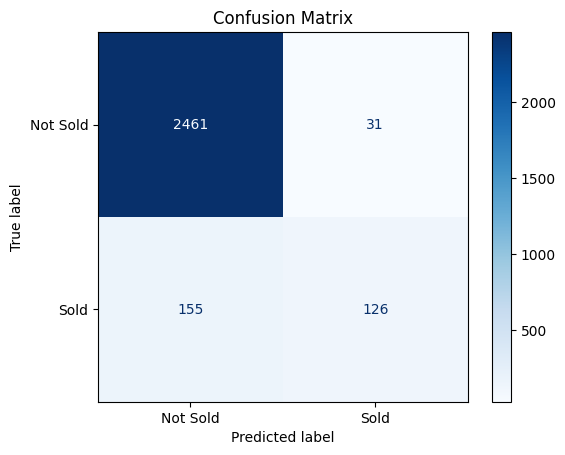

In [36]:
cm = confusion_matrix(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Sold", "Sold"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Error analysis

In [ ]:
columns = [
    'item_index',
    'bid',
    'buyout',
    'quantity',
    'time_left',
    'current_hours',
    'hours_on_sale',
    'prediction_q10',
    'prediction_q50',
    'prediction_q90',
    'prediction_interval',
    'sale_probability'
]

df_error = df_auctions_filtered[columns].copy()
df_error['error'] = np.abs(df_error['hours_on_sale'] - df_error['prediction_q50'])

df_error.sample(5)

In [ ]:
df_error['time_left'].hist(bins=10)

In [ ]:
plt.boxplot(df_error[['hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90']])
plt.xticks(ticks=[1,2,3,4], labels=['hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90'])
plt.grid()
plt.show()

In [ ]:
# Define bins for hours_on_sale
bins = [(0,12), (12,24), (24,48)]

# Calculate mean error for each bin
for start, end in bins:
    mask = (df_error['hours_on_sale'] >= start) & (df_error['hours_on_sale'] <= end)
    mean_error = df_error[mask]['error'].mean()
    print(f"Mean error for hours {start}-{end}: {mean_error:.2f}")

# Create boxplot showing error distribution in each bin
error_by_bin = []
labels = []
for start, end in bins:
    mask = (df_error['hours_on_sale'] >= start) & (df_error['hours_on_sale'] <= end)
    error_by_bin.append(df_error[mask]['error'])
    labels.append(f"{start}-{end}h")

plt.boxplot(error_by_bin, labels=labels)
plt.title("Error Distribution by Hours on Sale")
plt.ylabel("Absolute Error")
plt.xlabel("Hours on Sale Range") 
plt.grid()
plt.show()

In [ ]:
# histogram of hours on sale and prediction
plt.hist(df_error['hours_on_sale'], bins=100, alpha=0.5, label='Hours on sale')
plt.hist(df_error['prediction_q50'], bins=100, alpha=0.5, label='Prediction')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
plt.hist(df_error['current_hours'], bins=15)
plt.grid()
plt.show()

We are interested in evaluating the model when the items are recently published, because this will be the main use case for the model

In [ ]:
query = (df_error['current_hours'] <= 12) & (df_error['time_left'] == 48.0)
query_df = df_error[query]
print(f"Mean sale probability: {query_df['sale_probability'].mean()}")
print(f"Mean error: {query_df['error'].mean()}")
print(f"Mean hours on sale: {query_df['hours_on_sale'].mean()}")
query_df.sample(10)

In [ ]:
query_df['hours_on_sale'].hist(bins=10)
plt.grid()
plt.show()

In [ ]:
corr_matrix = df_error[['bid', 'buyout', 'time_left', 'current_hours', 'sale_probability',
                        'hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90', 'prediction_interval', 'error']].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1, 
            center=0,
            fmt='.2f',
            square=True) 

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

# Eval validation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import sys
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None

from pathlib import Path

repo_root = Path.cwd().parent.resolve()
sys.path.append(str(repo_root))

from sklearn.model_selection import train_test_split
from src.data.auction_dataset import AuctionDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
filters = [
    ("g_hours_on_sale_max", "<=", 50),
    ("g_current_hours_max", "<=", 50),
    ("g_hours_on_sale_len", "<=", 64),
    ("record", ">=", "2025-07-01"),
    ("record", "<=", "2025-09-01"),
]

pairs = pd.read_parquet("../generated/indices.parquet", engine="pyarrow", filters=filters)

split_idx = int(len(pairs) * 0.95)

train_pairs = pairs.iloc[:split_idx]
train_pairs = train_pairs.iloc[: int(len(train_pairs) * 0.90)]

print(f"Train pairs: {len(train_pairs)}")

val_pairs = pairs.iloc[split_idx:]

print(f"Val pairs: {len(val_pairs)}")

del pairs

In [ ]:
from src.data.auction_dataset import AuctionDataset
from src.data.utils import collate_auctions

batch_size = 16
max_hours_back = 24

val_dataset = AuctionDataset(val_pairs, feature_stats=feature_stats, path='../generated/sequences.h5', max_hours_back=max_hours_back)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_auctions) 

In [ ]:
# validate_and_noise.py

import itertools
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm


# ───────────────────────────────────────────────────────────────────────────────
# 1) Helper: build a hashable signature of everything the network can actually
#    distinguish once log1p + norm have been undone.
#    (Same fields as before; model now also sees hour_of_week/time_offset, but
#     we keep the signature aligned with original invariants.)
# ───────────────────────────────────────────────────────────────────────────────
def auction_signature(item_idx,
                      quantity,
                      buyout_gold,
                      context,
                      time_left,
                      current_hours,
                      bonus_lists,
                      modifier_types,
                      age_bucket=1.0):  # 1-hour buckets
    price_sig = round(float(buyout_gold), 2)   # 0.01 g precision
    age_sig   = int(current_hours // age_bucket)

    return (
        int(item_idx),
        int(quantity),
        price_sig,
        int(context),
        int(time_left),
        age_sig,
        tuple(sorted(bonus_lists)),
        tuple(sorted(modifier_types)),
    )


# ───────────────────────────────────────────────────────────────────────────────
# 2) Validation + noise-floor loop (updated for new dataloader/model)
# ───────────────────────────────────────────────────────────────────────────────
def evaluate_with_noise(model, val_loader, feature_stats, max_val_batches=10000, device="cuda"):
    """
    Args
    ----
    model : AuctionTransformer (quantile outputs)
    val_loader : DataLoader yielding dict-batches from AuctionDataset
    feature_stats : {'means': tensor(5,), 'stds': tensor(5,), ...}
    device : str
    require_full_duration : bool
        If True, restrict metrics/noise-floor to time_left==48.0 (like before).
    """

    means = feature_stats["means"].detach().cpu().numpy()   # first 5 auction cols
    stds  = feature_stats["stds"].detach().cpu().numpy()

    total_mse   = 0.0
    total_mae   = 0.0
    total_items = 0.0

    targets_by_sig = defaultdict(list)

    # median channel = tau=0.5
    # Try to find it; fallback to middle channel if needed.
    if hasattr(model, "quantiles") and 0.5 in model.quantiles:
        median_idx = model.quantiles.index(0.5)
    else:
        # Fallback: assume 3 quantiles [0.1,0.5,0.9]
        median_idx = 1

    model.eval()
    with torch.no_grad():
        i = 0
        for batch in tqdm(val_loader, desc="Validating"):
            if i > max_val_batches:
                break
            i += 1
            # ---- move to device ------------------------------------------------
            auctions        = batch['auctions'].to(device)           # (B,S,5) z-scored; bid/buyout were log1p pre-norm
            item_index      = batch['item_index'].to(device)         # (B,S)
            contexts        = batch['contexts'].to(device)           # (B,S)
            bonus_lists     = batch['bonus_lists'].to(device)        # (B,S,K)
            modifier_types  = batch['modifier_types'].to(device)     # (B,S,M)
            modifier_values = batch['modifier_values'].to(device)    # (B,S,M) already log1p and normed
            hour_of_week    = batch['hour_of_week'].to(device)       # (B,S)
            time_offset     = batch['time_offset'].to(device)        # (B,S)
            y               = batch['target'].to(device)             # (B,S) in HOURS (0..48)

            current_hours_raw = batch['current_hours_raw'].to(device)  # (B,S)
            time_left_raw     = batch['time_left_raw'].to(device)      # (B,S)

            # ---- forward -------------------------------------------------------
            y_hat_all = model((
                auctions, item_index, contexts, bonus_lists,
                modifier_types, modifier_values, hour_of_week, time_offset
            ))                                                      # (B,S,Q)

            # Take median channel (hours)
            y_hat = y_hat_all[..., median_idx]                      # (B,S)

            # ---- masks ---------------------------------------------------------
            # real items
            mask = (item_index != 0)

            # only current auctions (time_offset == 0)
            mask = mask & (time_offset == 0)
            mask = mask & (current_hours_raw == 0.0)
            mask = mask & (time_left_raw == 48.0)

            mask_f = mask.float()

            # ---- losses/metrics (in HOURS) ------------------------------------
            # MSE and MAE on masked entries
            sq_err_sum = ((y_hat - y) ** 2 * mask_f).sum()
            abs_err_sum = (torch.abs(y_hat - y) * mask_f).sum()
            n_items = mask_f.sum().item()

            total_mse   += sq_err_sum.item()
            total_mae   += abs_err_sum.item()
            total_items += n_items

            # ---- collect targets for irreducible-noise estimate ----------------
            # Work on CPU/numpy
            y_cpu               = y.detach().cpu().numpy()
            mask_cpu            = mask.detach().cpu().numpy()
            item_idx_cpu        = item_index.detach().cpu().numpy()
            auctions_cpu        = auctions.detach().cpu().numpy()       # z-scores
            contexts_cpu        = contexts.detach().cpu().numpy()
            time_left_cpu       = time_left_raw.detach().cpu().numpy()
            current_hours_cpu   = current_hours_raw.detach().cpu().numpy()
            bonus_lists_cpu     = bonus_lists.detach().cpu().numpy()
            modifier_types_cpu  = modifier_types.detach().cpu().numpy()

            B, S, _ = auctions_cpu.shape
            for b in range(B):
                for s in range(S):
                    if not mask_cpu[b, s]:
                        continue

                    # ---- undo standardisation + log1p for BUYOUT ---------------
                    buyout_norm = auctions_cpu[b, s, 1]
                    log_buyout  = buyout_norm * stds[1] + means[1]
                    buyout_gold = np.expm1(log_buyout)

                    # quantity column is linear but standardised
                    qty_norm = auctions_cpu[b, s, 2]
                    quantity = int(round(qty_norm * stds[2] + means[2]))

                    # build signature (strip zeros from K/M dims)
                    sig = auction_signature(
                        item_idx_cpu[b, s],
                        quantity,
                        buyout_gold,
                        contexts_cpu[b, s],
                        time_left_cpu[b, s],
                        current_hours_cpu[b, s],
                        bonus_lists_cpu[b, s][bonus_lists_cpu[b, s] != 0],
                        modifier_types_cpu[b, s][modifier_types_cpu[b, s] != 0],
                    )

                    targets_by_sig[sig].append(float(y_cpu[b, s]))

    # ── aggregate --------------------------------------------------------------
    if total_items > 0:
        avg_mse = total_mse / total_items
        avg_mae = total_mae / total_items
    else:
        avg_mse = float('nan')
        avg_mae = float('nan')

    # Pairwise absolute diffs for signatures with ≥2 targets (Bayesian lower bound)
    noise_sum   = 0.0
    noise_count = 0
    for t_list in targets_by_sig.values():
        if len(t_list) < 2:
            continue
        for a, b in itertools.combinations(t_list, 2):
            noise_sum   += abs(a - b)
            noise_count += 1

    irreducible_mae = noise_sum / noise_count if noise_count else 0.0

    print(f"Validation MSE          : {avg_mse:.4f} (hours^2)")
    print(f"Validation MAE          : {avg_mae:.4f} hours")
    print(f"Bayesian lower-bound MAE: {irreducible_mae:.4f} hours")

    return avg_mse, avg_mae, irreducible_mae


# Example call (match your training device variable/name)
evaluate_with_noise(model, val_dataloader, feature_stats, device=device)

In [ ]:
from src.models.inference import predict_dataframe

predict_dataframe(model, df_auctions[df_auctions['item_index'] == 13815], prediction_time, feature_stats)